# SMITH TUTORIAL

Welcome to the SMITH tutorial jupyter notebook!  The SMITH library (Neuroelectrics) is used to create Ising models from BOLD or EEG filtered amplituded enveloped data. 

Here we work with fMRI data. We binarize the data with the binarization module, then estimate the Ising parameters from the binarized data with iTailor, and create iNeTs (Ising Neurotwin) and simulate them with the iNeT module. Also, if you have created an "archetype" Ising model, using concatenated data from lots of data/subjects, you can create personalized Ising models with the iTailor module by fitting the system temperature.


Ref: Ruffini et al 2022 https://www.biorxiv.org/content/10.1101/2022.08.27.505518v3 

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext autotime
%config InlineBackend.figure_format = 'retina'

import numpy as np
import scipy as sp
import scipy.io as sio
import matplotlib.pyplot as plt
import sys
import os
import time
import pickle
from os.path import dirname, join as pjoin

neurotwin_source_dir: str = dirname(dirname(os.getcwd()))
sys.path.append(neurotwin_source_dir)
sys.path.append(os.path.dirname(neurotwin_source_dir))

from neurotwin.applications.smith.utils import binarize
from neurotwin.applications.smith.itailor import Itailor
from neurotwin.applications.smith.inet import Inet


time: 1.1 s (started: 2022-12-23 11:03:53 +01:00)


For the demo we will use the LSD dataset used in Niko's TFM. To use this we first want to create a function to symmetryze the ROI order of our data:

In [2]:
# Get AAL labels from pickle file
AAL_file = open(pjoin('data','supp_data', 'AAL.pkl'), 'rb')

AAL_dict = pickle.load(AAL_file)
AAL_file.close()
parcel_IDs = [AAL_dict[n][0] for n in range(1,91)]

def symmetrize_aal(data):
    """This function takes the original LSD dataset for a subject and condition and changes the order of the ROIs,
    so that we have them symmetrized"""
    ordered = np.zeros([90,217])
    odd = np.linspace(0,88,45, dtype = int)
    even = np.sort(np.linspace(1, 89, 45, dtype = int))[::-1]
    ordered[0:45, : ] = data[odd, :]
    ordered[45:90,:] = (data[even, :])
    return ordered

def large_plot(uu,title="", cmap = 'afmhot', clim=(-0.8,0.8)):
    """plotting helper"""
    fig, (ax1) = plt.subplots(1, 1,figsize=(15,15))
###############
    im1 = ax1.imshow(uu,origin='lower',cmap=cmap, clim=clim
               ,extent=[0.5,90.5,0.5,90.5])
    #im1.set_clim(-0.2,0.2)
    ax1.grid(linewidth=0.2)
    ax1.axhline(y=45,color='g',linewidth=0.1);
    ax1.axvline(x=45,color='g',linewidth=0.1);
    ax1.set_xticks(range(1,91))
    ax1.set_xticklabels(parcel_IDs,rotation=70, ha="right")
    ax1.set_yticks(range(1,91))
    ax1.set_yticklabels(parcel_IDs,rotation=20, ha="right")

    fig.colorbar(im1,ax=ax1,fraction=0.045, pad=0.06,
                 label="",location='right' )
    ax1.set_title(title )
    plt.show()   

time: 1.99 ms (started: 2022-12-23 11:03:54 +01:00)


## load the data

In [3]:
# from numpy file
lsd_data = np.load(pjoin('data','lsd', 'LSD_all.npy'), allow_pickle=True)

# Assign each session to a different variable
lsd_session1 = lsd_data[:,0]
lsd_session2 = lsd_data[:,2]
plcb_session1 = lsd_data[:,3]
plcb_session2 = lsd_data[:,5]
number_subjects = lsd_data[:,0].shape[0]

time: 8.54 ms (started: 2022-12-23 11:03:54 +01:00)


In [4]:
# alternatively from mat file

# Data path
mat_fname = pjoin('data','lsd', 'LSD_aal.mat')

# Load Data
# It's a 15x6 array: 15 subjects with 6 sessions each
lsd_datab = sio.loadmat(mat_fname)['tc_aal']
print('The number of subjects is', lsd_data.shape[0])
n_subjects = lsd_datab.shape[0]
print('The number of sessions is', lsd_datab.shape[1])

# The data from each session is a 90x217 array: 90 ROIs (AAL areas) and 217 timesteps
print('The number of ROIs is', lsd_datab[0,0].shape[0])
print('The number of timesteps is', lsd_datab[0,0].shape[1])

# Assign each session to a different variable. Here we exclude two sessions that 
# were carried out with music (the middle session for both lsd and placebo)
lsd_session1b = lsd_datab[:,0]
lsd_session2b = lsd_datab[:,2]
plcb_session1b = lsd_datab[:,3]
plcb_session2b = lsd_datab[:,5]

The number of subjects is 15
The number of sessions is 6
The number of ROIs is 90
The number of timesteps is 217
time: 79.8 ms (started: 2022-12-23 11:03:54 +01:00)


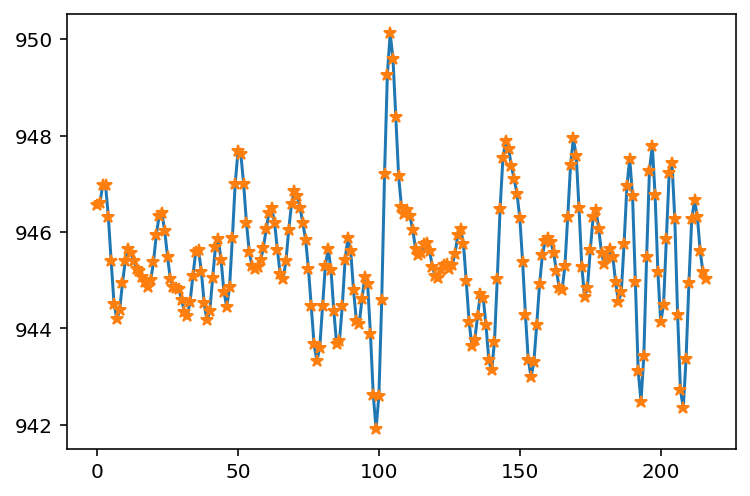

time: 148 ms (started: 2022-12-23 11:03:54 +01:00)


In [5]:
plt.plot(lsd_session1[0][0,:])
plt.plot(lsd_session1b[0][0,:],'*')

## reorder the parcels to symmetrize labels 

In [6]:
lsd_data.shape

(15, 6)

time: 1.92 ms (started: 2022-12-23 11:03:54 +01:00)


In [7]:
symmetric_lsd_session1 = dict()
symmetric_lsd_session2 = dict()
symmetric_plcb_session1 = dict()
symmetric_plcb_session2 = dict()

# Reorder the data and save it by session in dictionary with subject as key
for subject in range(number_subjects):
    symmetric_lsd_session1[str(subject)] = symmetrize_aal(lsd_session1[subject])
    symmetric_lsd_session2[str(subject)] = symmetrize_aal(lsd_session2[subject])
    symmetric_plcb_session1[str(subject)] = symmetrize_aal(plcb_session1[subject])
    symmetric_plcb_session2[str(subject)] = symmetrize_aal(plcb_session2[subject])

time: 12.3 ms (started: 2022-12-23 11:03:54 +01:00)


## binarize data using median 

In [8]:
# Binarize the data
binarized_lsd_session1 = dict()
binarized_lsd_session2 = dict()
binarized_plcb_session1 = dict()
binarized_plcb_session2 = dict()

for subject in range(number_subjects):
    binarized_lsd_session1[str(subject)] = binarize(symmetric_lsd_session1[str(subject)], "median")
    binarized_lsd_session2[str(subject)] = binarize(symmetric_lsd_session2[str(subject)], "median")
    binarized_plcb_session1[str(subject)] = binarize(symmetric_plcb_session1[str(subject)], "median")
    binarized_plcb_session2[str(subject)] = binarize(symmetric_plcb_session2[str(subject)], "median")

time: 80.6 ms (started: 2022-12-23 11:03:54 +01:00)


## check binarization

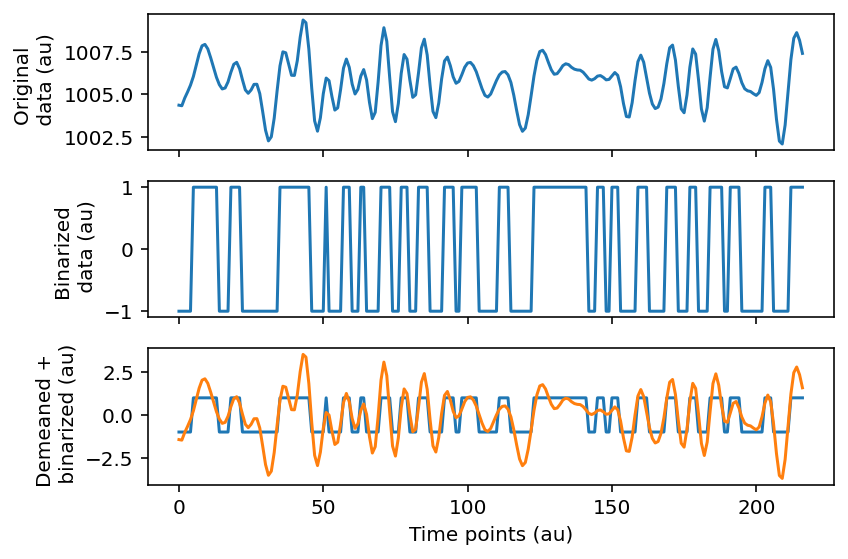

time: 270 ms (started: 2022-12-23 11:03:54 +01:00)


In [9]:
fig,axs = plt.subplots(3,1,sharex=True)
axs[0].plot(symmetric_lsd_session1["1"][0,:])
axs[1].plot(binarized_lsd_session1["1"][0,:])
axs[2].plot(binarized_lsd_session1["1"][0,:])
axs[2].plot(symmetric_lsd_session1["1"][0,:]-np.mean((symmetric_lsd_session1["1"][0,:])))
axs[2].set_xlabel('Time points (au)')
axs[0].set_ylabel('Original \n data (au)')
axs[1].set_ylabel('Binarized \n data (au)')
axs[2].set_ylabel("Demeaned + \n binarized (au)")
plt.tight_layout()

## iNeT and iTailor Class

Now that we have the binarized data let's show how to create an archetype and afterwards some personalized iNeTs

### concatenate data in each session

In [10]:
# Pre-allocate arrays for all LSD and all placebo binarized data
# by joining data from session 1 and session 2 for each condition.

binarized_data_lsd = np.empty_like(lsd_session1)
binarized_data_plcb = np.empty_like(plcb_session1)

for subject in range(number_subjects):
    binarized_data_lsd[subject] = \
        np.concatenate((binarized_lsd_session1[str(subject)],
                        binarized_lsd_session2[str(subject)]), axis=1)
    binarized_data_plcb[subject] = \
        np.concatenate((binarized_plcb_session1[str(subject)],
                        binarized_plcb_session2[str(subject)]), axis=1)

time: 5.53 ms (started: 2022-12-23 11:03:55 +01:00)


### concatenate  data for archetype creation

In [11]:
# Concantenate all the data
"""
First we concatenate all the binarized data (so that we have the data from all
subjects in the archetype) that will be the input of the Itailor module.
"""
for subject in range(number_subjects):
    if subject == 0:
        all_data = np.concatenate(
            (binarized_data_lsd[subject], binarized_data_plcb[subject]), axis=1)
    else:
        all_data = np.concatenate(
        (all_data, binarized_data_lsd[subject], binarized_data_plcb[subject]), axis=1)

all_data = np.matrix(all_data, dtype=float)

time: 45.8 ms (started: 2022-12-23 11:03:55 +01:00)


In [12]:
# Concantenate all the LSD data
"""
First we concatenate all the binarized data (so that we have the data from all
subjects in the archetype) that will be the input of the Itailor module.
"""
for subject in range(number_subjects):
    if subject == 0:
        all_data =  binarized_data_lsd[subject] 
    else:
        all_data = np.concatenate(
        (all_data, binarized_data_lsd[subject]), axis=1)

all_lsd_data = np.matrix(all_data, dtype=float)

time: 16.7 ms (started: 2022-12-23 11:03:55 +01:00)


In [13]:
# Concantenate all the PCB data
"""
First we concatenate all the binarized data (so that we have the data from all
subjects in the archetype) that will be the input of the Itailor module.
"""
for subject in range(number_subjects):
    if subject == 0:
        all_data =  binarized_data_plcb[subject] 
    else:
        all_data = np.concatenate(
        (all_data, binarized_data_plcb[subject]), axis=1)

all_plcb_data = np.matrix(all_data, dtype=float)

time: 14 ms (started: 2022-12-23 11:03:55 +01:00)


Now that we have the data, we will proceed to create the archetype i.e. estimate the ising model parameters from the data mean and correlation. Let's show these data variables first:

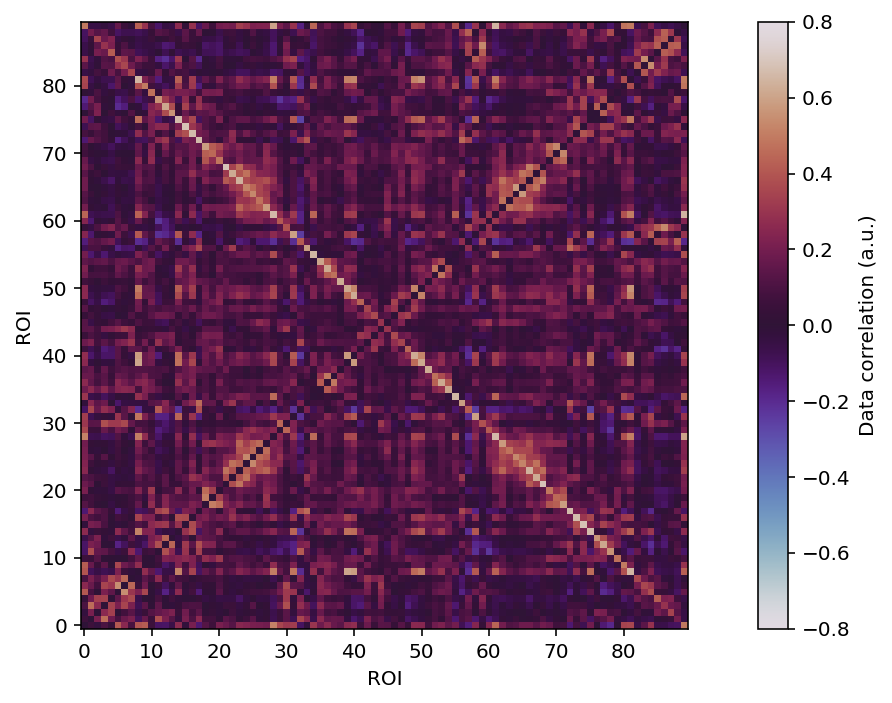

time: 279 ms (started: 2022-12-23 11:03:55 +01:00)


In [14]:
plt.figure(figsize = (10,5))
FC_all_data = np.corrcoef(all_data)
np.fill_diagonal(FC_all_data,0)
plt.imshow(FC_all_data, origin='lower', clim=(-0.8,0.8), cmap='twilight')
plt.xlabel('ROI')
plt.ylabel('ROI')
clb = plt.colorbar(label='Data correlation (a.u.)')
plt.tight_layout()
plt.show()

### create the global archetype with Itailor:

Now let's take this data from all the subjects altogether and use the iTailor class to estimate the archetype
that describes all this data.

In [15]:
# Define size of the iNeT
n_rois = all_data.shape[0]

# Create the variables needed to create the inet object
# Create empty ising parameters
h_archetype = np.zeros(n_rois)
j_archetype = np.zeros([n_rois, n_rois])
# Create empty iNeT
archetype_inet = Inet(h_archetype, j_archetype)

# Create the archetype dictionary (input for iTailor). In this case, as we
# create an archetype and we are not estimating personalized models, we do not
# give an archetype to it, so we pass None. We pass the empty inet object to
# the itailor class and the data to update that empty inet to an archetype.
archetype_dictionary = dict()
archetype_dictionary["inet"] = archetype_inet
archetype_dictionary["archetype_h"] = None
archetype_dictionary["archetype_j"] = None
archetype_tailor = Itailor(archetype_dictionary, all_data)

# Set the method parameters for estimating the archetype
params_method = dict()
params_method["delta_t"] = 0.05
params_method["iteration_max"] = 8000
params_method["permissible_error"] = 1e-9
# Run the ezaki method to estimate h and J and update those attributes h and J
# to the object
archetype_tailor.run("archetype", params_method)

Itailor params: {'delta_t': 0.05, 'iteration_max': 8000, 'permissible_error': 1e-09, 'sparsity': 0, 'estimate_h': True}
number of steps: 0 norm: 0.0018396146726852285
number of steps: 500 norm: 1.5058369670376074e-06
number of steps: 1000 norm: 6.463475496643802e-08
number of steps: 1500 norm: 3.6033025557629067e-09
stopped after 1730 steps
time: 43.8 s (started: 2022-12-23 11:03:55 +01:00)


### PLCB archetype

In [16]:

# Create the variables needed to create the inet object
# Create empty ising parameters
h_archetype = np.zeros(n_rois)
j_archetype = np.zeros([n_rois, n_rois])
# Create empty iNeT
archetype_inet_plcb = Inet(h_archetype, j_archetype)

# Create the archetype dictionary (input for iTailor). In this case, as we
# create an archetype and we are not estimating personalized models, we do not
# give an archetype to it, so we pass None. We pass the empty inet object to
# the itailor class and the data to update that empty inet to an archetype.
archetype_dictionary = dict()
archetype_dictionary["inet"] = archetype_inet_plcb 
archetype_dictionary["archetype_h"] = None
archetype_dictionary["archetype_j"] = None
archetype_tailor = Itailor(archetype_dictionary, all_plcb_data)

# Set the method parameters for estimating the archetype
params_method = dict()
params_method["delta_t"] = 0.05
params_method["iteration_max"] = 8000
params_method["permissible_error"] = 1e-9
# Run the ezaki method to estimate h and J and update those attributes h and J
# to the object
archetype_tailor.run("archetype", params_method)

Itailor params: {'delta_t': 0.05, 'iteration_max': 8000, 'permissible_error': 1e-09, 'sparsity': 0, 'estimate_h': True}
number of steps: 0 norm: 0.0018396146726852285
number of steps: 500 norm: 1.5058369670376074e-06
number of steps: 1000 norm: 6.463475496643802e-08
number of steps: 1500 norm: 3.6033025557629067e-09
stopped after 1730 steps
time: 46.6 s (started: 2022-12-23 11:04:39 +01:00)


### LSD archetype

In [17]:

# Create the variables needed to create the inet object
# Create empty ising parameters
h_archetype = np.zeros(n_rois)
j_archetype = np.zeros([n_rois, n_rois])
# Create empty iNeT
archetype_inet_lsd = Inet(h_archetype, j_archetype)

# Create the archetype dictionary (input for iTailor). In this case, as we
# create an archetype and we are not estimating personalized models, we do not
# give an archetype to it, so we pass None. We pass the empty inet object to
# the itailor class and the data to update that empty inet to an archetype.
archetype_dictionary = dict()
archetype_dictionary["inet"] = archetype_inet_lsd 
archetype_dictionary["archetype_h"] = None
archetype_dictionary["archetype_j"] = None
archetype_tailor = Itailor(archetype_dictionary, all_lsd_data)

# Set the method parameters for estimating the archetype
params_method = dict()
params_method["delta_t"] = 0.05
params_method["iteration_max"] = 8000
params_method["permissible_error"] = 1e-9
# Run the ezaki method to estimate h and J and update those attributes h and J
# to the object
archetype_tailor.run("archetype", params_method)

Itailor params: {'delta_t': 0.05, 'iteration_max': 8000, 'permissible_error': 1e-09, 'sparsity': 0, 'estimate_h': True}
number of steps: 0 norm: 0.00182683670267374
number of steps: 500 norm: 1.098356563495941e-06
number of steps: 1000 norm: 3.583714856102927e-08
number of steps: 1500 norm: 1.5893806483571917e-09
stopped after 1577 steps
time: 41.8 s (started: 2022-12-23 11:05:25 +01:00)


### plot archetypes J

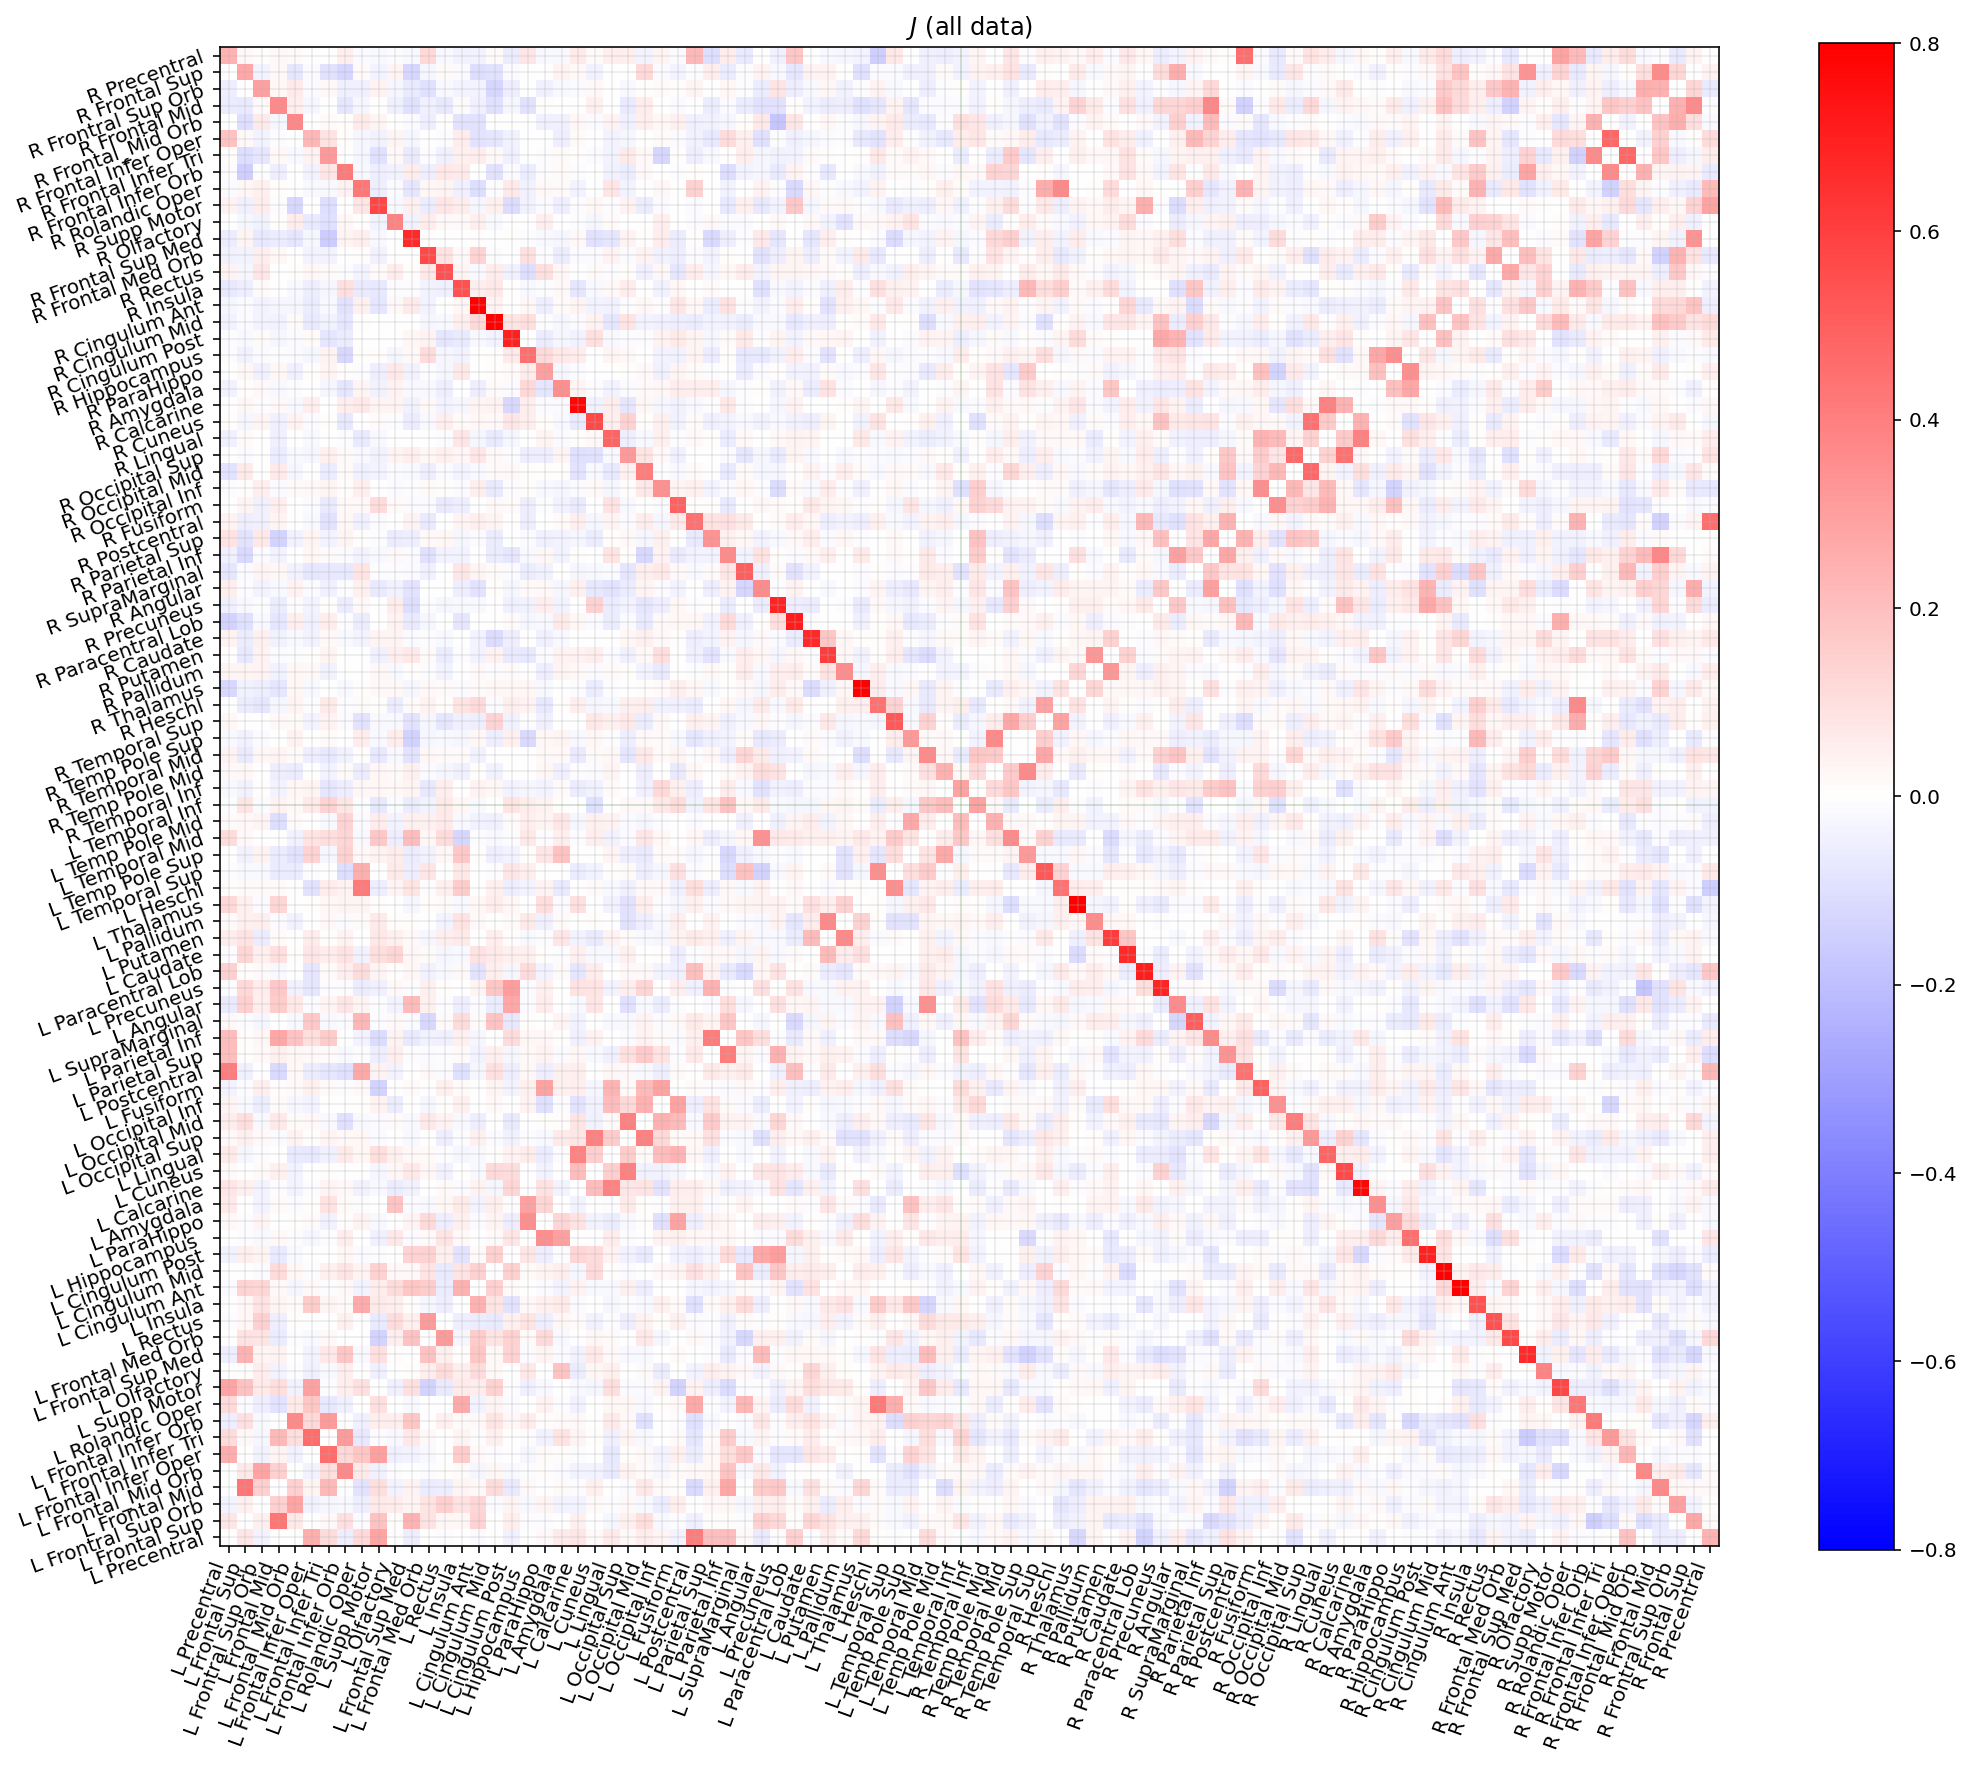

time: 2.74 s (started: 2022-12-23 11:06:07 +01:00)


In [18]:
large_plot(archetype_inet.j_ising,title=r"$J$ (all data)", cmap = 'bwr')    

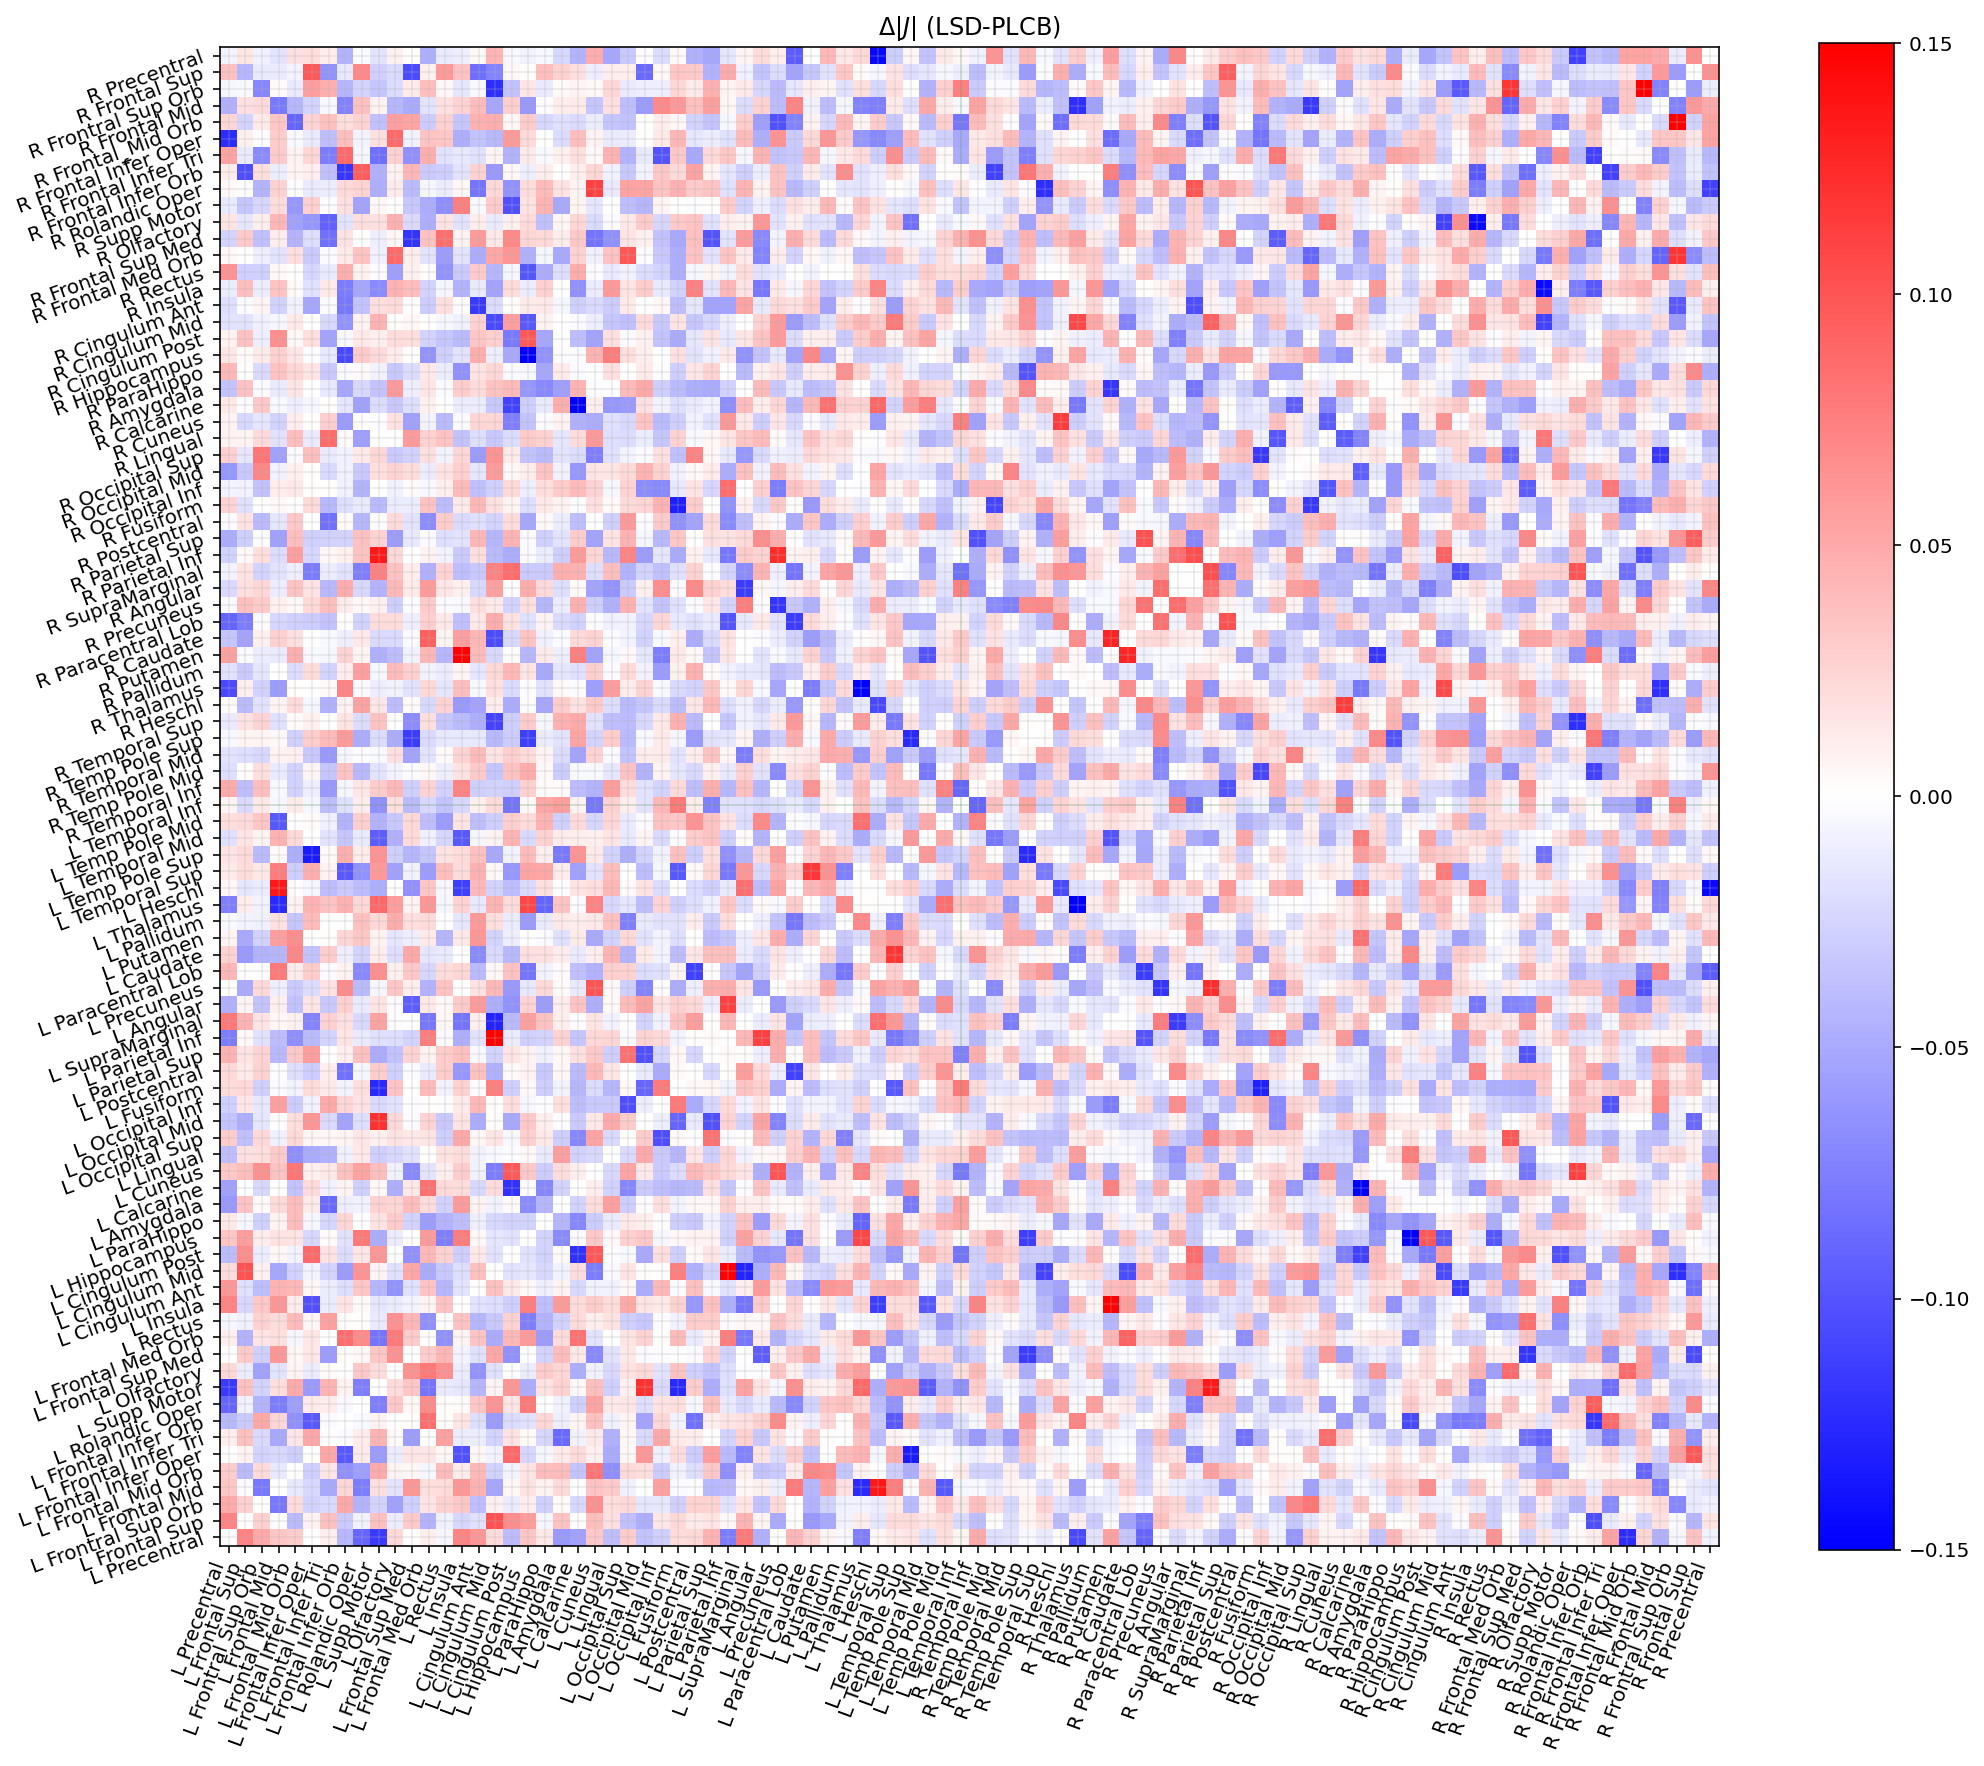

time: 2.4 s (started: 2022-12-23 11:06:10 +01:00)


In [19]:
large_plot(np.abs(archetype_inet_lsd.j_ising)-np.abs(archetype_inet_plcb.j_ising),
           title=r"$\Delta |J|$ (LSD-PLCB)", cmap = 'bwr', clim=(-0.15,0.15))  

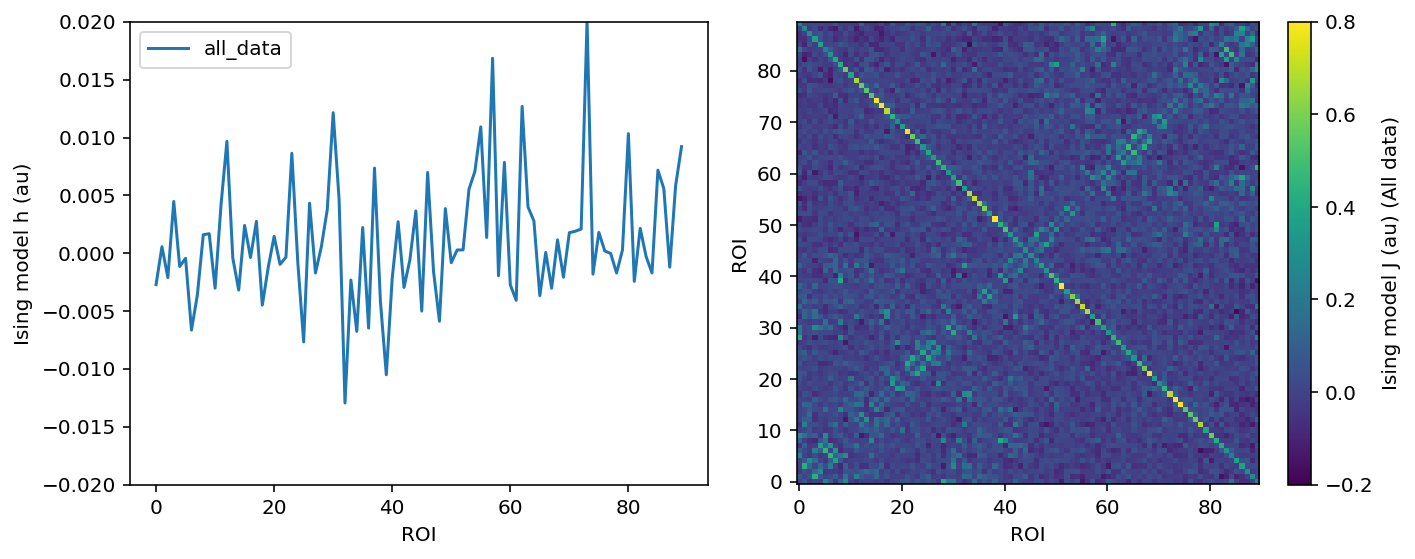

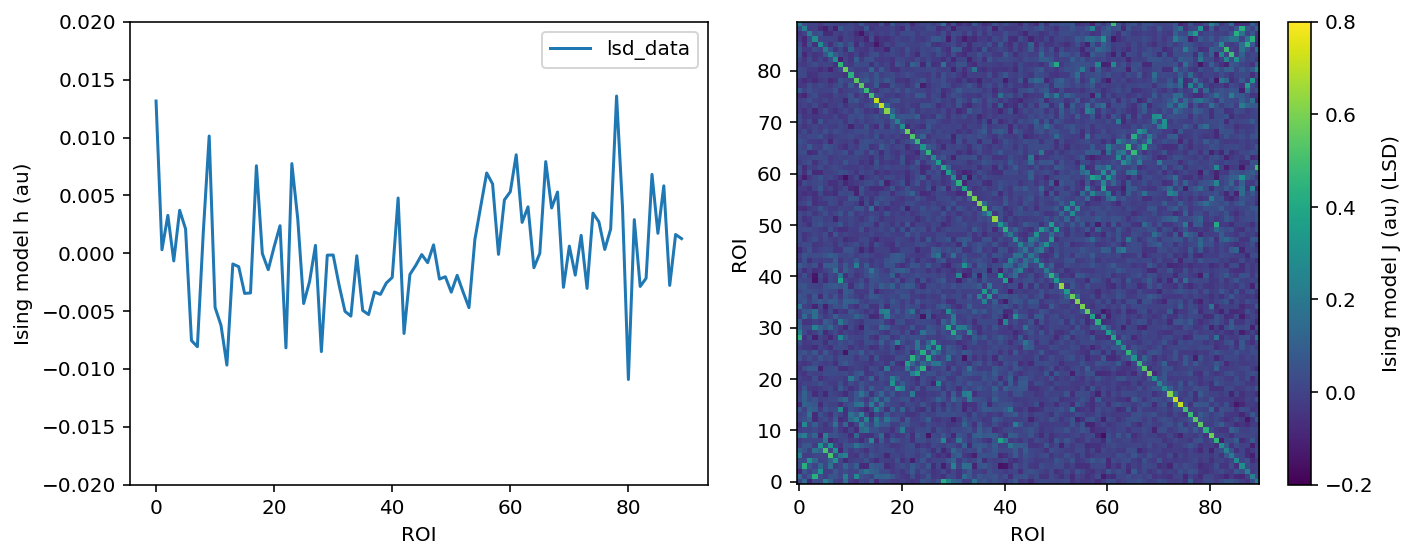

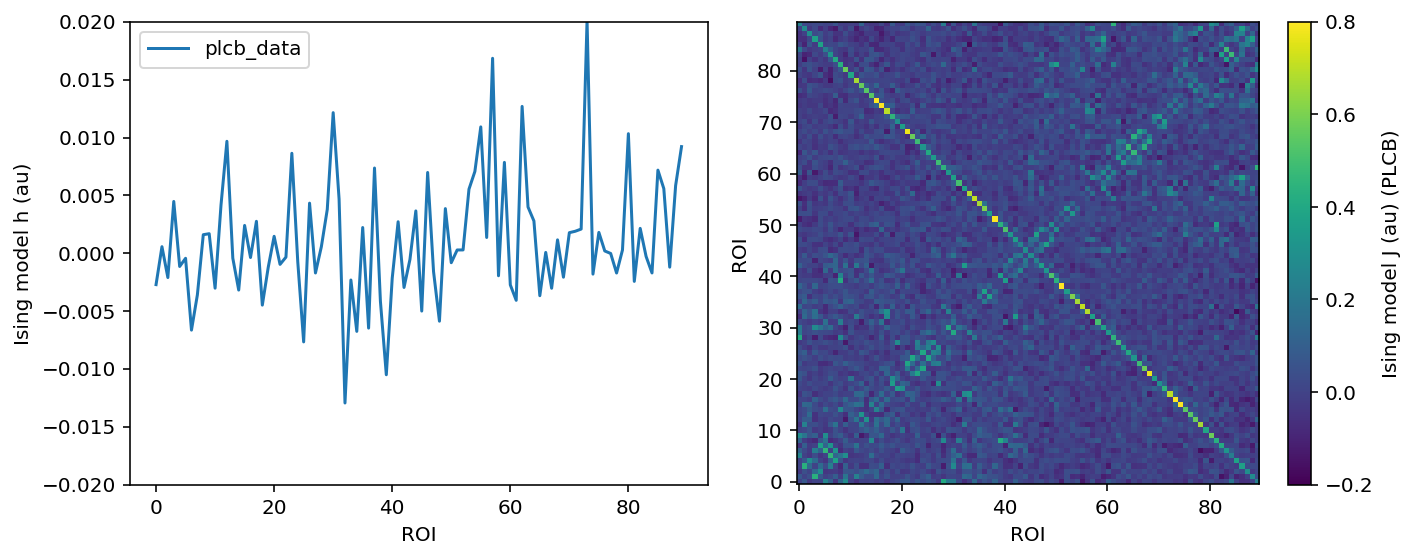

time: 1.12 s (started: 2022-12-23 11:06:12 +01:00)


In [20]:
# Show both h and J results
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.xlabel("ROI")
plt.ylabel("Ising model h (au)")
plt.plot(archetype_inet.h_ising, label='all_data')
plt.legend()
plt.ylim(-0.02,0.02)
plt.subplot(1,2,2)
plt.imshow(archetype_inet.j_ising, origin='lower',clim=(-0.2,0.8))
clb = plt.colorbar(label='Ising model J (au) (All data)')
plt.ylabel("ROI")
plt.xlabel("ROI")

plt.tight_layout()

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.xlabel("ROI")
plt.ylabel("Ising model h (au)")
plt.plot(archetype_inet_lsd.h_ising, label='lsd_data')
plt.legend()
plt.ylim(-0.02,0.02)
plt.subplot(1,2,2)
plt.imshow(archetype_inet_lsd.j_ising, origin='lower', clim=(-0.2,0.8))
clb = plt.colorbar(label='Ising model J (au) (LSD)')
plt.ylabel("ROI")
plt.xlabel("ROI")
plt.tight_layout()

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.xlabel("ROI")
plt.ylabel("Ising model h (au)")
plt.plot(archetype_inet_plcb.h_ising, label='plcb_data')
plt.legend()
plt.ylim(-0.02,0.02)
plt.subplot(1,2,2)
plt.imshow(archetype_inet_plcb.j_ising, origin='lower',clim=(-0.2,0.8))
clb = plt.colorbar(label='Ising model J (au) (PLCB)')
plt.ylabel("ROI")
plt.xlabel("ROI")
plt.tight_layout()

## Create Personalized iNeTs

Here, we have to use the individual data (from each subject in the two different conditions: either LSD or placebo) to get personalized models.
We will concatenate for each subject her/his 2 measurements in the same conditions (LSD session 1 + LSD session 2, placebo session 1 + placebo session 2).

In [21]:
def personalize_T(archetype_inet, subject_data):
    """Personalize T for each subect from archetype (actually beta =1/t) and
    fullpack dictionary dataset ()'binTS' data)"""
    #
    n_parcels = np.array(subject_data).shape[0] # assume data shape is n_parcels x n_timepoints
    Ts = list()
    
    #Create the empty personalized iNet
    subj_h = np.zeros(n_parcels)
    subj_j = np.zeros([n_parcels,n_parcels])
    subj_inet = Inet(subj_h, subj_j)
    #Create the attributes for the itailor class, in this case we give the archetype we created before 
    #and the personal data
    inet_dictionary = dict()
    inet_dictionary["inet"] = subj_inet
    inet_dictionary["archetype_h"] = np.matrix(archetype_inet.h_ising, dtype=float)  #Use the archetype we derived before
    inet_dictionary["archetype_j"] = np.matrix(archetype_inet.j_ising, dtype=float)

    # Itailor object inputs archetype dictionary with J,h + the data for the subject:
    subj_tailor = Itailor(inet_dictionary, subject_data)

    # Set the parameters for the personalizion method
    betas = np.arange(0.7, 1.5,0.001)
    subj_tailor.run("personalized_H",{}, betas) #Get personalized h and J for subj_01
     
    print("subject T:", 1./subj_inet.beta,
          "fit error:",subj_tailor.method_output["minimum error"] )

        
    return 1./subj_inet.beta

time: 1.08 ms (started: 2022-12-23 11:06:14 +01:00)


In [22]:
personalize_T(archetype_inet, binarized_data_lsd[0])

# All LSD
temperatures_inets_lsd_both_sess  = [personalize_T(archetype_inet, binarized_data_lsd[subj]) 
                                     for subj in range(number_subjects)]

# All placebo
temperatures_inets_plcb_both_sess  = [personalize_T(archetype_inet, binarized_data_plcb[subj]) 
                                      for subj in range(number_subjects)]

Itailor params: {'permissible_error': 1e-09, 'delta_t': 0.05, 'iteration_max': 1000, 'sparsity': 0, 'estimate_h': True}
subject T: 1.1834319526627217 fit error: 6.205013106715554e-07
Itailor params: {'permissible_error': 1e-09, 'delta_t': 0.05, 'iteration_max': 1000, 'sparsity': 0, 'estimate_h': True}
subject T: 1.1834319526627217 fit error: 6.205013106715554e-07
Itailor params: {'permissible_error': 1e-09, 'delta_t': 0.05, 'iteration_max': 1000, 'sparsity': 0, 'estimate_h': True}
subject T: 1.2210012210012209 fit error: 7.336240872827755e-07
Itailor params: {'permissible_error': 1e-09, 'delta_t': 0.05, 'iteration_max': 1000, 'sparsity': 0, 'estimate_h': True}
subject T: 1.1574074074074072 fit error: 9.369876710429341e-07
Itailor params: {'permissible_error': 1e-09, 'delta_t': 0.05, 'iteration_max': 1000, 'sparsity': 0, 'estimate_h': True}
subject T: 1.148105625717566 fit error: 1.788522724437663e-07
Itailor params: {'permissible_error': 1e-09, 'delta_t': 0.05, 'iteration_max': 1000, '

Temperatures for all subjects under LSD
[1.1834319526627217, 1.2210012210012209, 1.1574074074074072, 1.148105625717566, 1.2330456226880393, 1.1834319526627217, 1.2610340479192939, 1.212121212121212, 1.2077294685990336, 1.3123359580052494, 1.1160714285714284, 1.1534025374855823, 1.2360939431396785, 1.2300123001230012, 1.059322033898305]
Temperatures for all subjects under placebo
[1.0131712259371832, 0.9689922480620152, 1.0050251256281404, 0.9960159362549799, 0.9980039920159678, 1.0298661174047372, 0.9852216748768472, 1.0351966873706002, 1.0162601626016259, 0.9891196834817012, 1.0256410256410253, 1.011122345803842, 1.0131712259371832, 0.978473581213307, 0.9380863039399623]


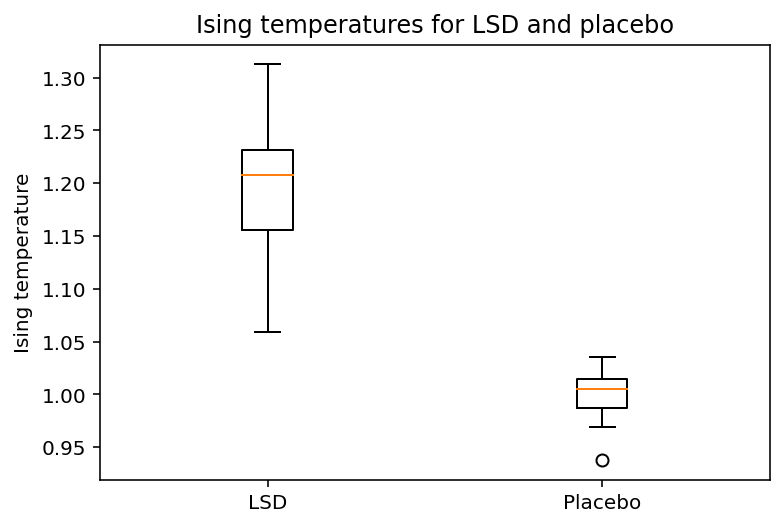

Cohen's d
3.1409983424652617
WilcoxonResult(statistic=0.0, pvalue=6.103515625e-05)
time: 140 ms (started: 2022-12-23 11:07:17 +01:00)


In [23]:
print('Temperatures for all subjects under LSD')
print(temperatures_inets_lsd_both_sess)
print('Temperatures for all subjects under placebo')
print(temperatures_inets_plcb_both_sess)

data = [temperatures_inets_lsd_both_sess, temperatures_inets_plcb_both_sess]
plt.title('Ising temperatures for LSD and placebo')
plt.boxplot(data)
plt.xticks([1, 2], ["LSD", "Placebo"])
plt.ylabel('Ising temperature')
plt.show()

contrast = np.array(temperatures_inets_lsd_both_sess)-np.array(temperatures_inets_plcb_both_sess)
cohensd = np.mean(contrast, axis=0)/np.std(contrast, axis=0)
print("Cohen's d")
print(cohensd)
from scipy import stats
print(stats.wilcoxon(contrast))

## Run the Metropolis algorithm with the archetype parameters

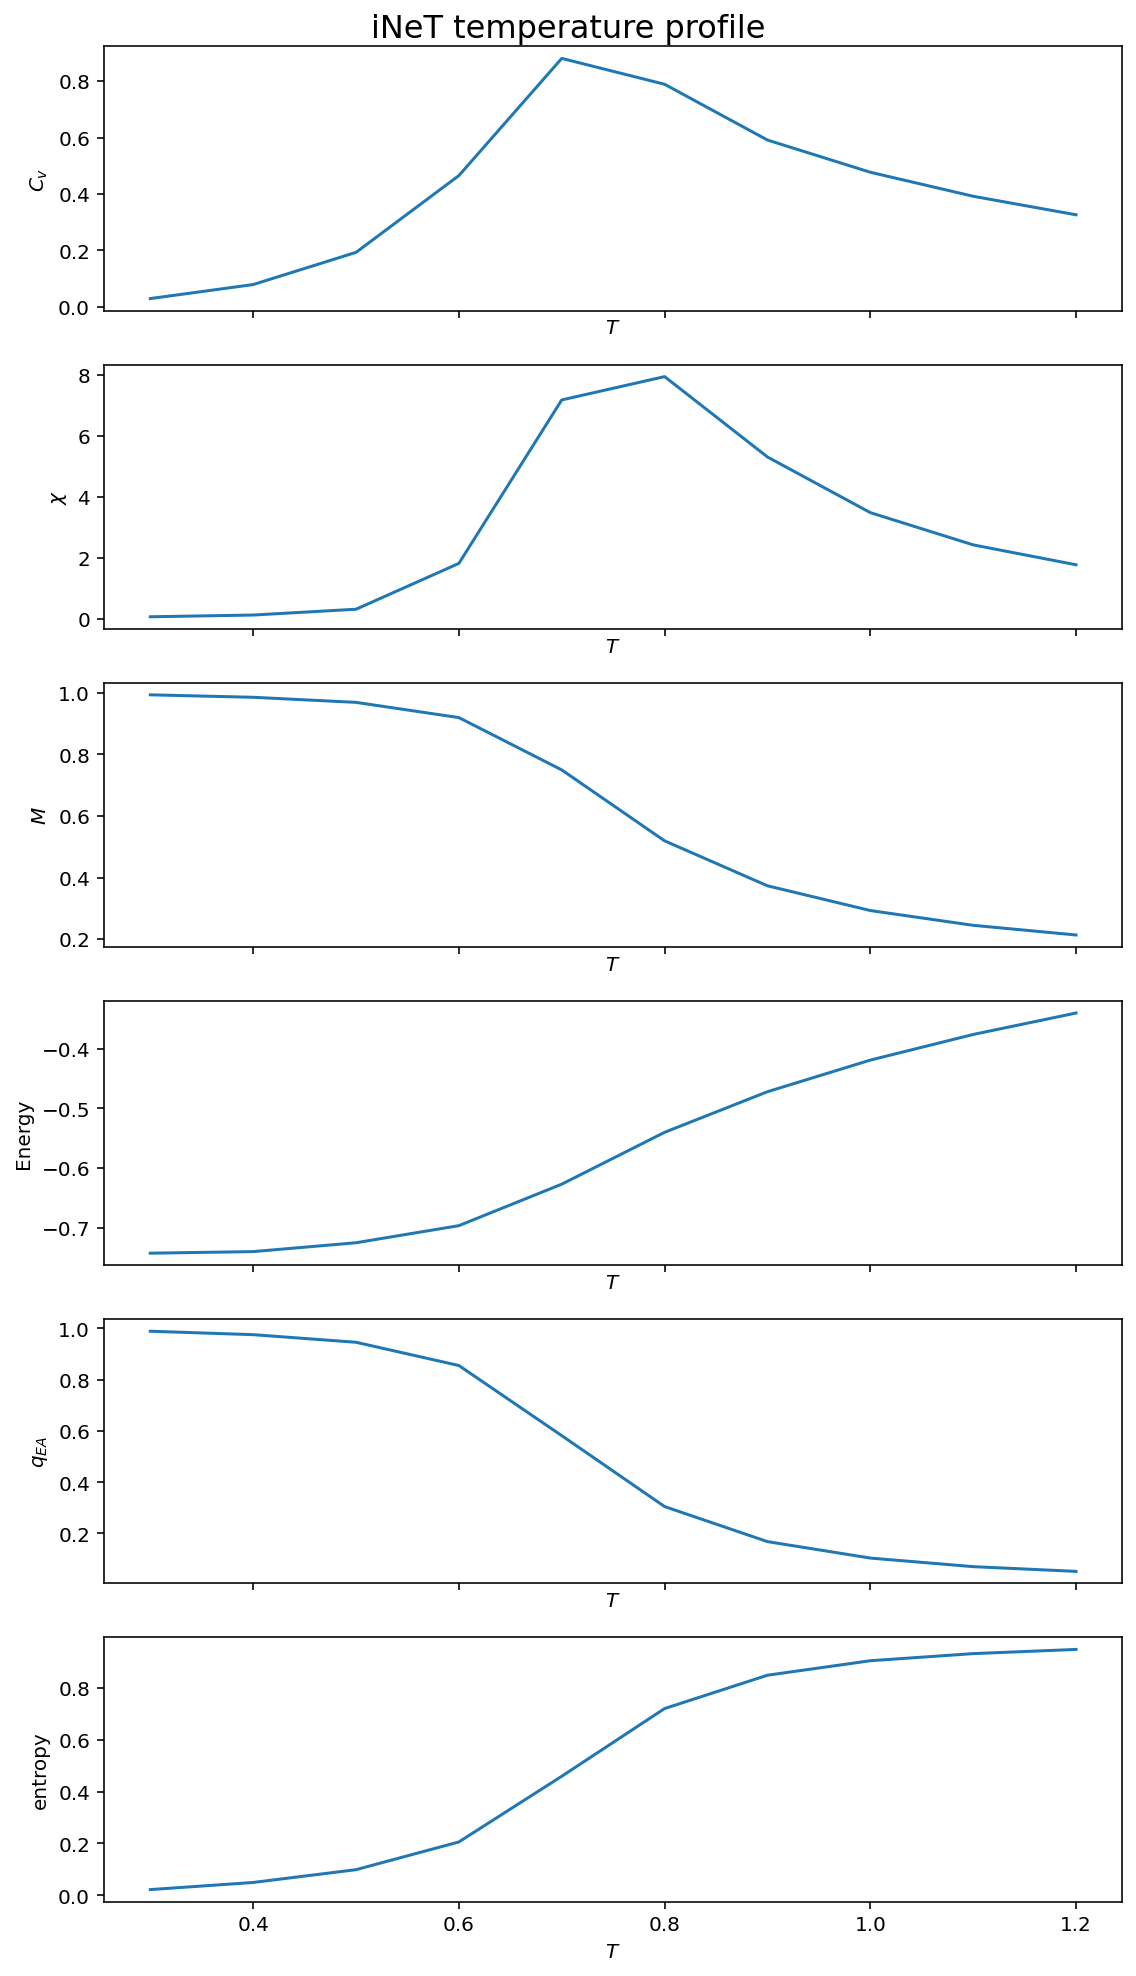

Tc: 0.8
Max chi: 7.93
total time was 0.31 hours
total time was 1120.44 seconds
time: 18min 40s (started: 2022-12-23 11:07:17 +01:00)


In [24]:
t = time.time()

temperatures = np.linspace(0.3, 1.2, 10) 
iterations = 50000000 # > 10e6

archetype_inet.h_ising = np.ravel(archetype_inet.h_ising)

[heats, susceptibilities,
                energies,
                magnetizations, q_EAs, entropies] = archetype_inet.simulate_and_plot(
    temperatures, iterations)

elapsed = time.time() - t
print('total time was', np.round(elapsed/3600, 2), 'hours')
print('total time was', np.round(elapsed, 2), 'seconds')

In [25]:
import scipy as sio
J_dict= {"J all data": np.array(archetype_inet.j_ising), 
 "J lsd data": np.array(archetype_inet_lsd.j_ising), 
 "J plcb data": np.array(archetype_inet_plcb.j_ising)}
sio.io.savemat("Js_lsd_experiment.mat", J_dict)

time: 2.69 ms (started: 2022-12-23 11:25:58 +01:00)


In [26]:
import scipy as sio
J_dict= {"J": np.array(archetype_inet_plcb.j_ising)}
sio.io.savemat("Js_plcb.mat", J_dict)

J_dict= {"J": np.array(archetype_inet_lsd.j_ising)}
sio.io.savemat("Js_lsd.mat", J_dict)

time: 17.2 ms (started: 2022-12-23 11:25:58 +01:00)


In [27]:
np.array(archetype_inet_plcb.j_ising)

array([[ 0.        ,  0.07576916, -0.03399966, ..., -0.05493915,
        -0.00112674,  0.23771808],
       [ 0.07576916,  0.        ,  0.04467424, ..., -0.00611304,
         0.27662589,  0.02207289],
       [-0.03399966,  0.04467424,  0.        , ...,  0.2980625 ,
        -0.03499363,  0.00859453],
       ...,
       [-0.05493915, -0.00611304,  0.2980625 , ...,  0.        ,
         0.12615016, -0.06255354],
       [-0.00112674,  0.27662589, -0.03499363, ...,  0.12615016,
         0.        ,  0.03988497],
       [ 0.23771808,  0.02207289,  0.00859453, ..., -0.06255354,
         0.03988497,  0.        ]])

time: 2.27 ms (started: 2022-12-23 11:25:58 +01:00)


In [28]:
lsd_data.shape

(15, 6)

time: 1.51 ms (started: 2022-12-23 11:25:58 +01:00)
